In [43]:
""" This is a generally useful header. If a module is changed, it will automatically be reloaded.
Obviously, this is much more convenient than having to restart the jupyter kernel!"""
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import numpy as np
import matplotlib.cm as cm

from scipy.integrate import quad
from scipy.interpolate import interp1d, RectBivariateSpline
from scipy.ndimage import gaussian_filter1d
import camb
from astropy.table import Table
import h5py
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcdefaults()

# Explore CAMB

In [45]:
#Set up a new set of parameters for CAMB
# For simplicity, we assume massless neutrinos
pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0., omk=0, tau=0.06,
                       As=2e-9, ns=0.965, lmax=3000)

In [46]:
#calculate results for these parameters
results = camb.get_results(pars)
#print(results)

Shape of Cl array: (3051, 4)


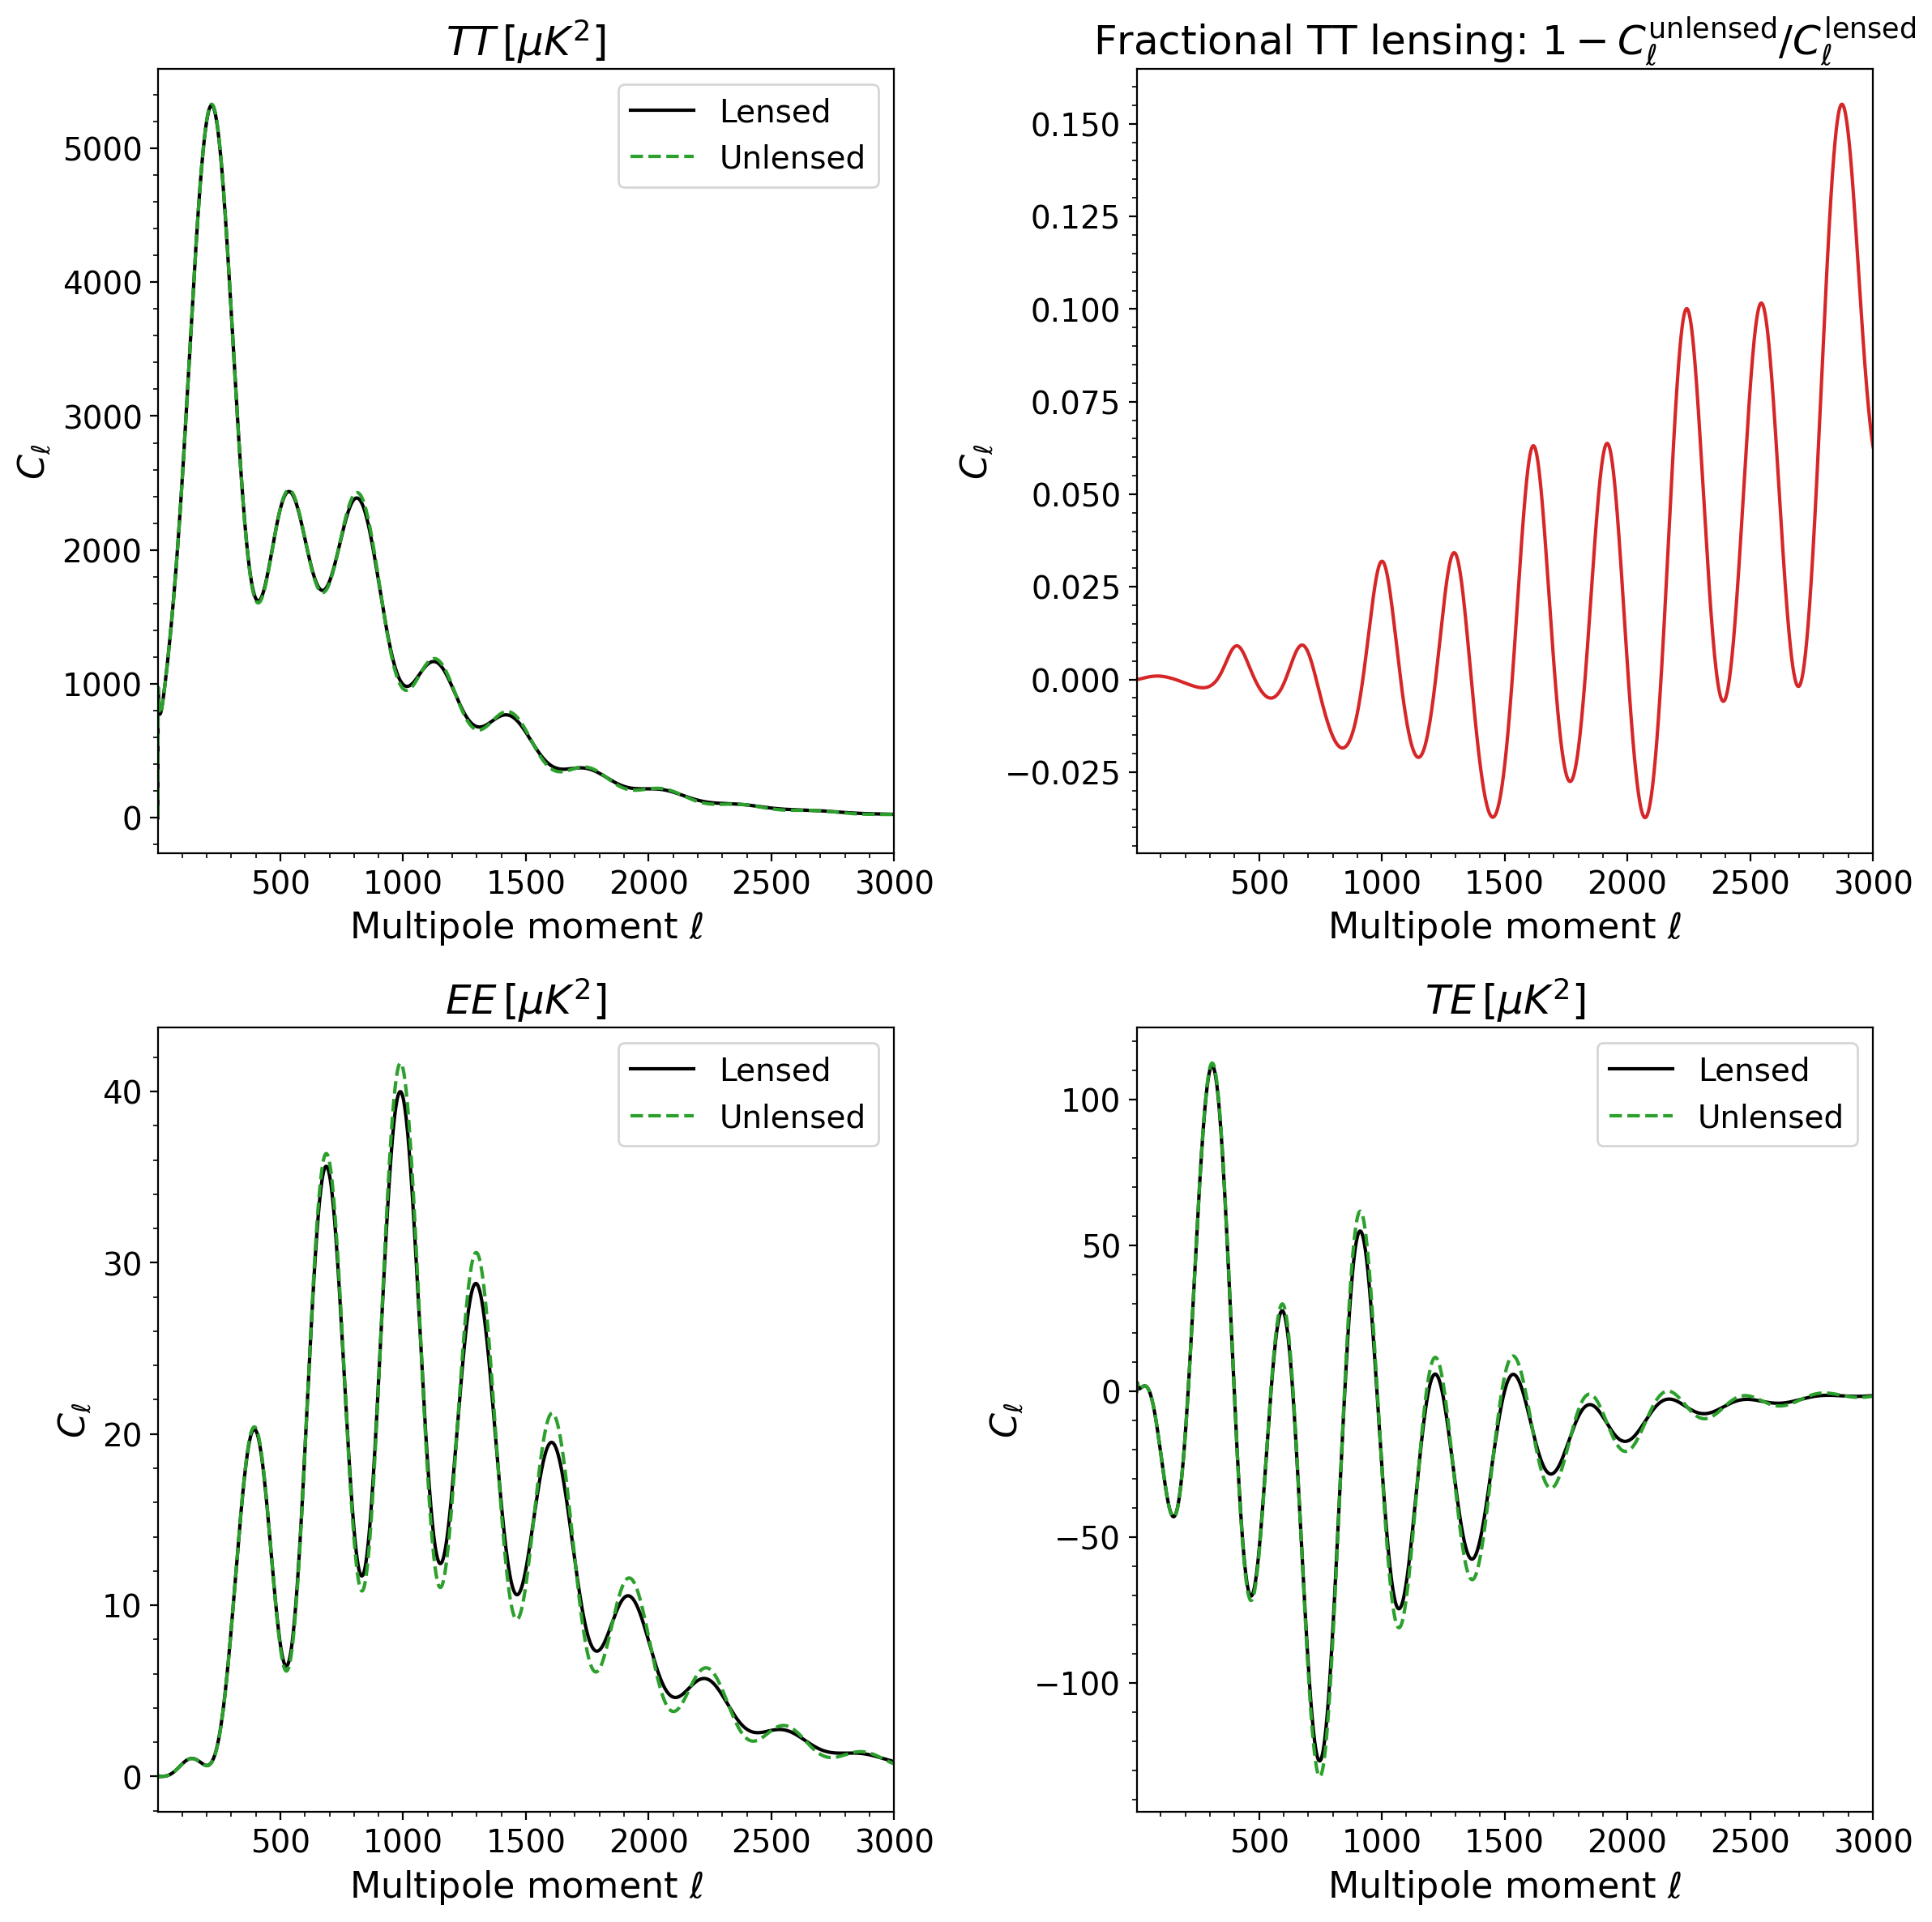

In [47]:
#get dictionary of CAMB power spectra
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')

# Extract total (lensed) and unlensed scalar spectra
totCL = powers['total']             # lensed
unlensedCL = powers['unlensed_scalar']  # unlensed

print("Shape of Cl array:", totCL.shape)

ls = np.arange(totCL.shape[0])  # Multipole range


# Plot
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

# Font size settings
title_fontsize = 18
label_fontsize = 16
tick_fontsize = 14
legend_fontsize = 14

# TT Spectrum
ax[0, 0].plot(ls, totCL[:, 0], color='k', label='Lensed')
ax[0, 0].plot(ls, unlensedCL[:, 0], color='C2', linestyle='--', label='Unlensed')
ax[0, 0].set_title(r'$TT\, [\mu K^2]$', fontsize=title_fontsize)
ax[0, 0].legend(fontsize=legend_fontsize)

# Fractional difference in TT
ax[0, 1].plot(ls[2:], 1 - unlensedCL[2:, 0] / totCL[2:, 0], color='C3')
ax[0, 1].set_title(r'Fractional TT lensing: $1 - C_\ell^\mathrm{unlensed}/C_\ell^\mathrm{lensed}$', fontsize=title_fontsize)

# EE Spectrum
ax[1, 0].plot(ls, totCL[:, 1], color='k', label='Lensed')
ax[1, 0].plot(ls, unlensedCL[:, 1], color='C2', linestyle='--', label='Unlensed')
ax[1, 0].set_title(r'$EE\, [\mu K^2]$', fontsize=title_fontsize)
ax[1, 0].legend(fontsize=legend_fontsize)

# TE Spectrum
ax[1, 1].plot(ls, totCL[:, 3], color='k', label='Lensed')
ax[1, 1].plot(ls, unlensedCL[:, 3], color='C2', linestyle='--', label='Unlensed')
ax[1, 1].set_title(r'$TE\, [\mu K^2]$', fontsize=title_fontsize)
ax[1, 1].legend(fontsize=legend_fontsize)

# General formatting for all axes
for axis in ax.reshape(-1):
    axis.set_xlim([2, 3000])
    axis.set_xlabel(r'Multipole moment $\ell$', fontsize=label_fontsize)
    axis.set_ylabel(r'$C_\ell$', fontsize=label_fontsize)
    axis.tick_params(axis='both', labelsize=tick_fontsize)
    axis.minorticks_on()

plt.tight_layout()
plt.savefig('lensedcamb_readable.png', dpi=300)
plt.show()


In [48]:
# Now get matter power spectra and sigma8 at redshift 0 and 0.8
# parameters can all be passed as a dict as above, or you can call 
# separate functions to set up the parameter object
pars.set_matter_power(redshifts=[0., 0.8], kmax=2.0)

#Linear spectra
pars.NonLinear = camb.model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=13, npoints = 301)
s8 = np.array(results.get_sigma8())

#Non-Linear spectra (Halofit)
pars.NonLinear = camb.model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)

Note: redshifts have been re-sorted (earliest first)


In [49]:
print(results.get_sigma8())

[0.54079283 0.81450702]


## Matter power spectrum 

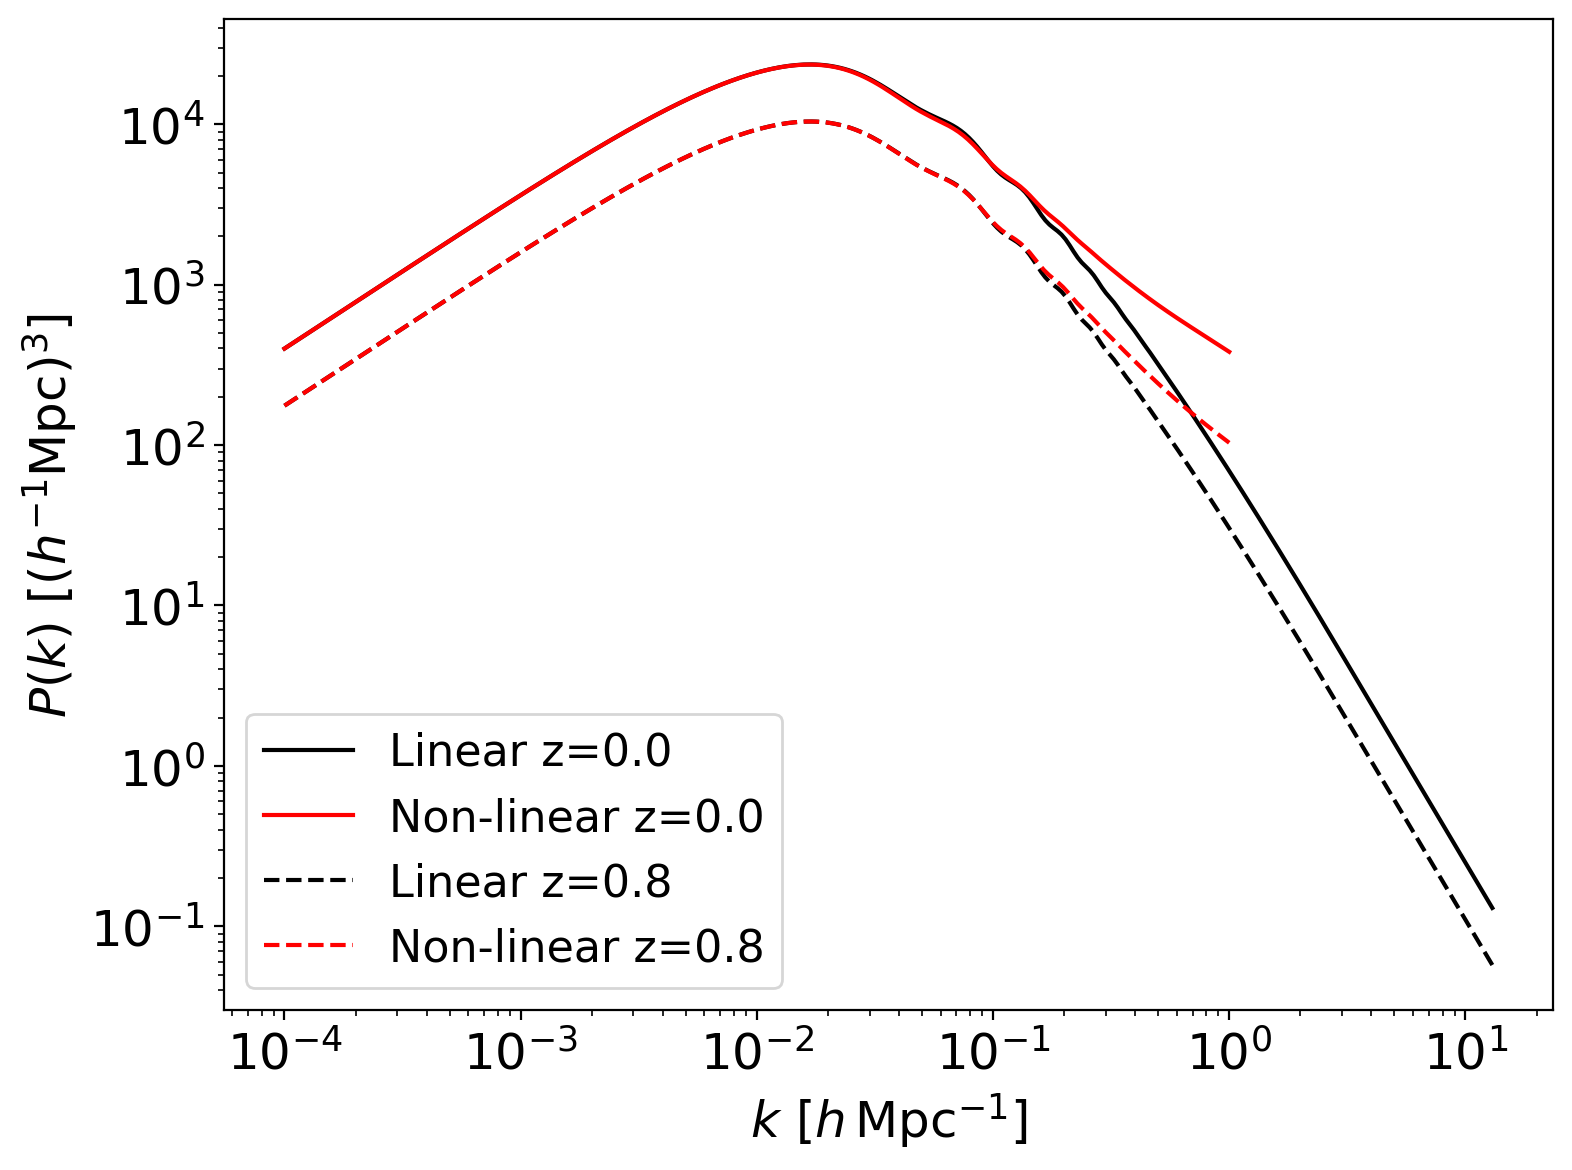

In [50]:
plt.figure(figsize=(8, 6))  # Larger figure for better readability
for i, (redshift, line) in enumerate(zip(z, ['-', '--'])):
    plt.loglog(kh, pk[i, :], color='k', ls=line, label=f'Linear z={redshift}')
    plt.loglog(kh_nonlin, pk_nonlin[i, :], color='r', ls=line, label=f'Non-linear z={redshift}')



plt.xlabel(r'$k\ [h\,\mathrm{Mpc}^{-1}]$', fontsize=18)
plt.ylabel(r'$P(k)\ [(h^{-1}\mathrm{Mpc})^3]$', fontsize=18)
plt.legend(fontsize=16, loc='lower left')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.minorticks_on()

plt.savefig('matter_power_spectrum.png', dpi=300)
plt.show()

In [9]:
# Display all model parameters. Can you identify the cosmological parameters?
#print(pars)

In [10]:
# We can use the `pars` object directly to manipulate parameters
# Let's try Omega_b h^2
print('ombh2', pars.ombh2)
# Total matter is cold dark matter + baryons (we assume massless neutrinos for this lab)
Ommh2 = pars.omch2 + pars.ombh2
pars.Omega_m = Ommh2 / pars.h**2
print('Omega_m', pars.Omega_m)

ombh2 0.022
Omega_m 0.3160493827160493


# The halo mass function
## Definition of cosmological functions

In [11]:
# See Theory task 6.

# Hubble distance c/H0 in units [h^{-1} Mpc]
DIST_H = 2997.92458
# Critical density at z=0, in units [h^2 Msun/Mpc^3]
RHOCRIT = 2.77537e11

In [12]:
# Cosmological functions - these should look familiar!
def Ez(z, pars):
    """Return the dimensionless Hubble parameter E(z) = H(z)/H0."""
    Omega_m0 = pars.Omega_m
    Omega_lambda0 = 1.0 - Omega_m0  # Assuming flat universe
    return np.sqrt(Omega_m0 * (1 + z)**3 + Omega_lambda0)

def Omega_m_z(z, pars):
    """Return Omega_m(z)."""
    Omega_m0 = pars.Omega_m
    Ez_val = Ez(z, pars)
    return Omega_m0 * (1 + z)**3 / Ez_val**2


def dA(z, pars):
    """Return angular diameter distance D_A(z) in units of Mpc/h."""
    c = 299792.458  # speed of light in km/s
    H0 = pars.H0
    Omega_m = pars.Omega_m
    Omega_lambda = 1.0 - Omega_m  # Assuming flat universe

    # Integrate c / H(z') from z'=0 to z'=z
    integrand = lambda zp: c / H_z(zp, H0, Omega_m, Omega_lambda)
    integral, _ = quad(integrand, 0, z)

    # Angular diameter distance
    d_A = integral / (1 + z)
    return d_A  # in units of Mpc/h


def deltaV(z_arr, pars, dOmega=1.0):
    """
    Return dV/dz/dOmega [(Mpc/h)^3 / steradian] as a function of redshift.
    """
    c = 299792.458  # km/s
    H0 = pars.H0
    Omega_m = pars.Omega_m
    Omega_lambda = 1.0 - Omega_m  # Assuming flat universe

    volumes = []
    for z in z_arr:
        # Angular diameter distance at z
        d_A_z = dA(z, pars)

        # Hubble parameter at z
        Hz = H_z(z, H0, Omega_m, Omega_lambda)

        # Volume element
        dV_dzdOmega = c / Hz * (1 + z)**2 * d_A_z**2 * dOmega
        volumes.append(dV_dzdOmega)

    return np.array(volumes)  # units: (Mpc/h)^3 per dz per steradian


In [13]:
def compute_sigma8(pars, k, Pk):
    """Return sigma_8 for a given input power spectrum Pk(k)."""
    R = 8.0  # Radius in Mpc/h for sigma_8
    kR = k * R
    
    # Top-hat window function in Fourier space
    window = 3 * (np.sin(kR) - kR * np.cos(kR)) / (kR**3)
    window[kR == 0] = 1e-6  # Handle the k=0 case to avoid division by zero
    
    integrand = k**2 * Pk * window**2
    sigma8_squared = np.trapz(integrand, k) / (2 * np.pi**2)
    sigma8 = np.sqrt(sigma8_squared)
    
    return sigma8

In [14]:
def compute_sigma_M(pars, k, Pk, M):
    """Return sigma(M) for given mass M in Msun/h."""
    # Constants
    RHOCRIT = 2.77537e11  # h^2 Msun/Mpc^3
    Omega_m = pars.Omega_m
    
    # Calculate smoothing radius R [Mpc/h]
    rho_m = Omega_m * RHOCRIT
    R = (3 * M / (4 * np.pi * rho_m))**(1/3)
    
    kR = k * R
    window = 3 * (np.sin(kR) - kR * np.cos(kR)) / (kR**3)
    window[kR == 0] = 1e-6  # handle k=0 case
    
    integrand = k**2 * Pk * window**2
    sigma2 = np.trapezoid(integrand, k) / (2 * np.pi**2)
    sigma_M = np.sqrt(sigma2)
    
    return sigma_M, integrand

## Integrand 

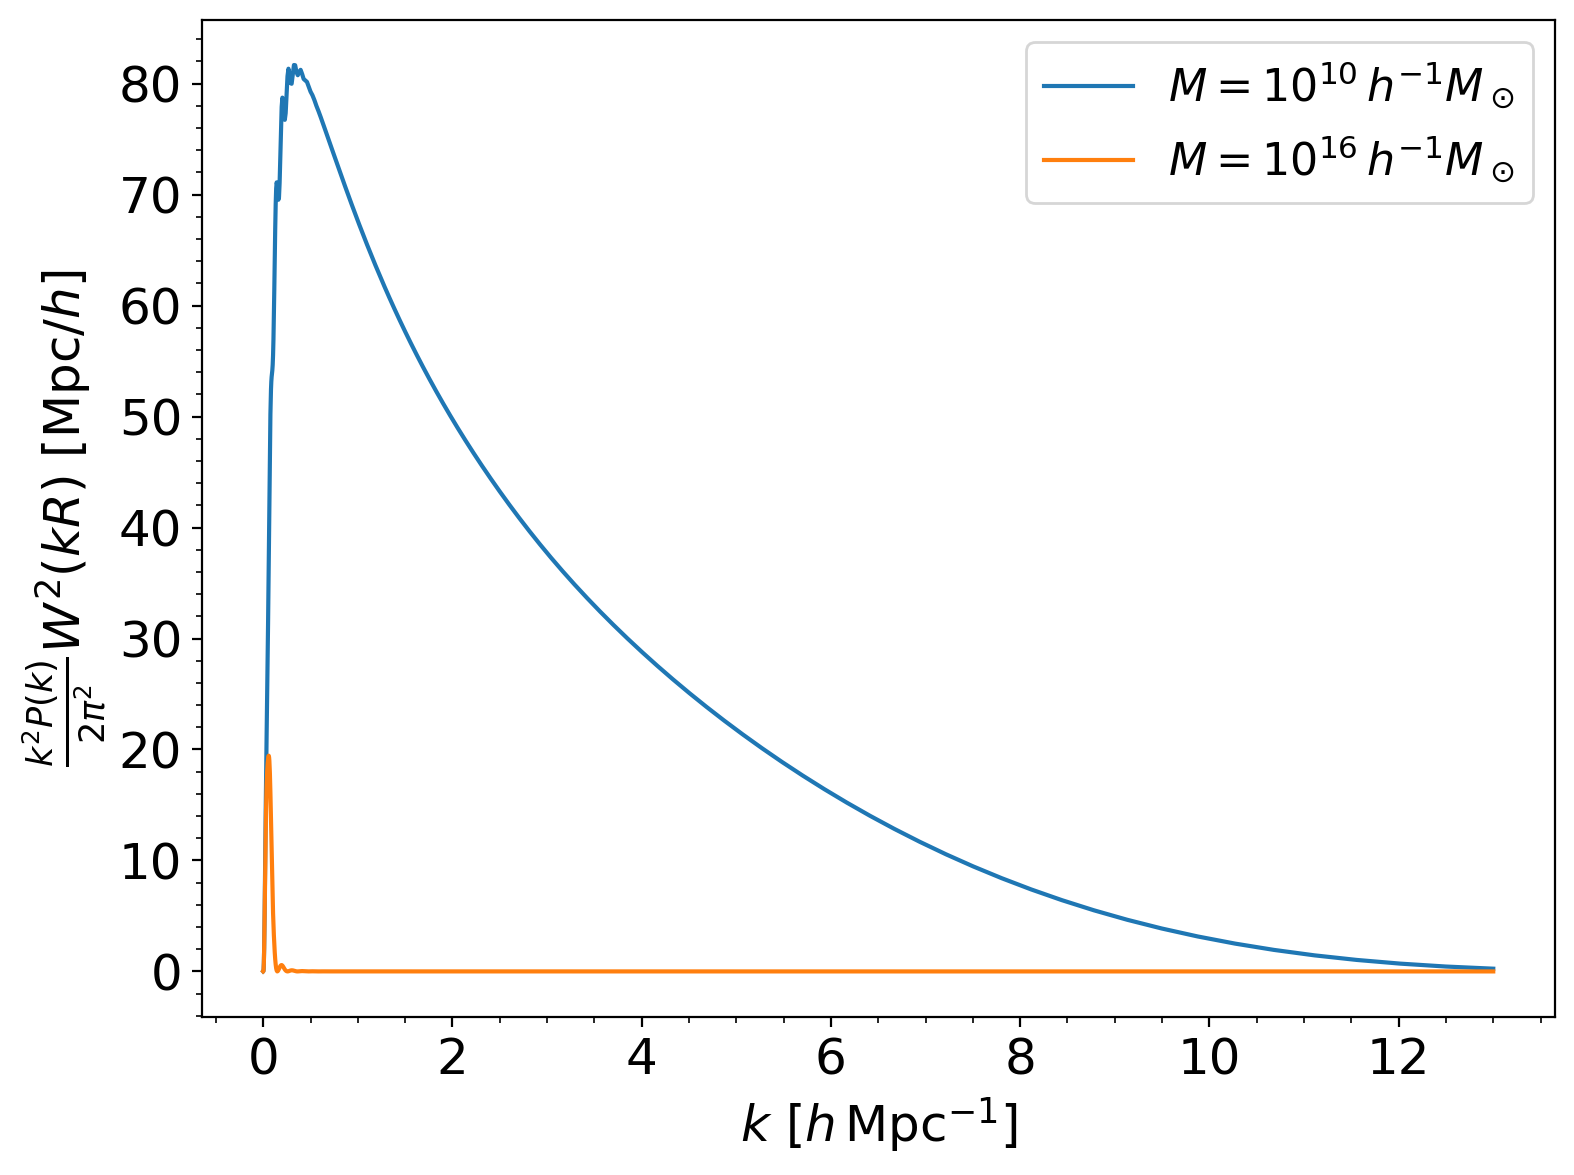

In [15]:
# Now compute the halo mass function
M = np.logspace(10, 16, 301)
_, integrand1 = compute_sigma_M(pars, kh, pk[0], M[0])
_, integrand2 = compute_sigma_M(pars, kh, pk[0], M[-1])

plt.figure(figsize=(8, 6))  # Larger figure size for clarity

plt.plot(kh, integrand1, label=r'$M = 10^{10}\,h^{-1} M_\odot$')
plt.plot(kh, integrand2, label=r'$M = 10^{16}\,h^{-1} M_\odot$')

# Axis labels with larger font
plt.xlabel(r'$k\ [h\,\mathrm{Mpc}^{-1}]$', fontsize=18)
plt.ylabel(r'$\frac{k^2 P(k)}{2\pi^2} W^2(kR)\ [\mathrm{Mpc}/h]$', fontsize=18)

# Title

# Tick label size
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=18)

# Legend with larger font
plt.legend(fontsize=16)

# Minor ticks
plt.minorticks_on()

# Save and show
plt.tight_layout()
plt.savefig('window.png', dpi=300)  # High-res output
plt.show()


### Inteporlating Tinker params 

In [16]:
# Tinker et al. (2008) halo mass function
# Initialize Tinker interpolation (A, a, b, c)
x = np.log((200., 300., 400., 600., 800., 1200., 1600., 2400., 3200.))
y = (1.858659e-01, 1.995973e-01, 2.115659e-01, 2.184113e-01, 2.480968e-01, 2.546053e-01, 2.600000e-01, 2.600000e-01, 2.600000e-01)
Tinker_A = interp1d(x, y, kind='cubic')
y = (1.466904e+00, 1.521782e+00, 1.559186e+00, 1.614585e+00, 1.869936e+00, 2.128056e+00, 2.301275e+00, 2.529241e+00, 2.661983e+00)
Tinker_a = interp1d(x, y, kind='cubic')
y = (2.571104e+00, 2.254217e+00, 2.048674e+00, 1.869559e+00, 1.588649e+00, 1.507134e+00, 1.464374e+00, 1.436827e+00, 1.405210e+00)
Tinker_b = interp1d(x, y, kind='cubic')
y = (1.193958e+00, 1.270316e+00, 1.335191e+00, 1.446266e+00, 1.581345e+00, 1.795050e+00, 1.965613e+00, 2.237466e+00, 2.439729e+00)
Tinker_c = interp1d(x, y, kind='cubic')

In [17]:
def compute_Tinker_HMF(Delta_mean, z, pars, sigma_M, dlnsigma_dlnM, M):
    """
    Compute dn/dlnM using Tinker et al. (2008).
    
    Inputs:
    - Delta_mean: overdensity definition (e.g., 200)
    - z: redshift
    - pars: CAMB parameters
    - sigma_M: sigma(M,z)
    - dlnsigma_dlnM: derivative of ln(sigma) w.r.t ln(M)
    - M: mass array (in Msun/h)
    
    Returns:
    - dn_dlnM: halo mass function [h^3 Mpc^-3]
    """
    # Mean matter density at z=0 [Msun/h/(Mpc/h)^3]
    RHOCRIT = 2.77537e11  # h^2 Msun/Mpc^3
    rho_m = pars.Omega_m * RHOCRIT

    # Interpolate Tinker parameters at Delta_mean
    logDelta = np.log(Delta_mean)
    A = Tinker_A(logDelta)
    a = Tinker_a(logDelta)
    b = Tinker_b(logDelta)
    c = Tinker_c(logDelta)
    
    # Redshift evolution
    logalpha = - (0.75 / np.log10(Delta_mean / 75.0))**1.2
    alpha = 10**logalpha
    
    A *= (1 + z)**-0.14
    a *= (1 + z)**-0.06
    b *= (1 + z)**-alpha
    # c no evolution
    
    # Compute f(sigma)
    fsigma = A * ((sigma_M / b)**(-a) + 1) * np.exp(-c / sigma_M**2)
    
    # Compute dn/dlnM
    dn_dlnM = - (rho_m / M) * fsigma * dlnsigma_dlnM
    
    return dn_dlnM


## Running the function 

In [18]:
# Now compute the halo mass function
M = np.logspace(10, 16, 301)
# 1. Compute sigma(M) array
sigma_M = np.array([compute_sigma_M(pars, kh, pk[0], mass)[0] for mass in M])
sigma_M_2 = np.array([compute_sigma_M(pars, kh, pk[1], mass)[0] for mass in M])

# 2. Compute dlnsigma/dlnM numerically
logM = np.log(M)
logsigma = np.log(sigma_M)
logsigma_2 = np.log(sigma_M_2)

dlnsigma_dlnM = np.gradient(logsigma, logM)
dlnsigma_dlnM_2 = np.gradient(logsigma_2, logM)

# 3. Set overdensity and redshift
Delta_mean = 200.0
# 4. Compute the halo mass function dn/dlnM
dn_dlnM = compute_Tinker_HMF(Delta_mean, 0, pars, sigma_M, dlnsigma_dlnM, M,)
dn_dlnM_2 = compute_Tinker_HMF(Delta_mean, 0.8, pars, sigma_M_2, dlnsigma_dlnM_2, M,)

## Plotting HMF

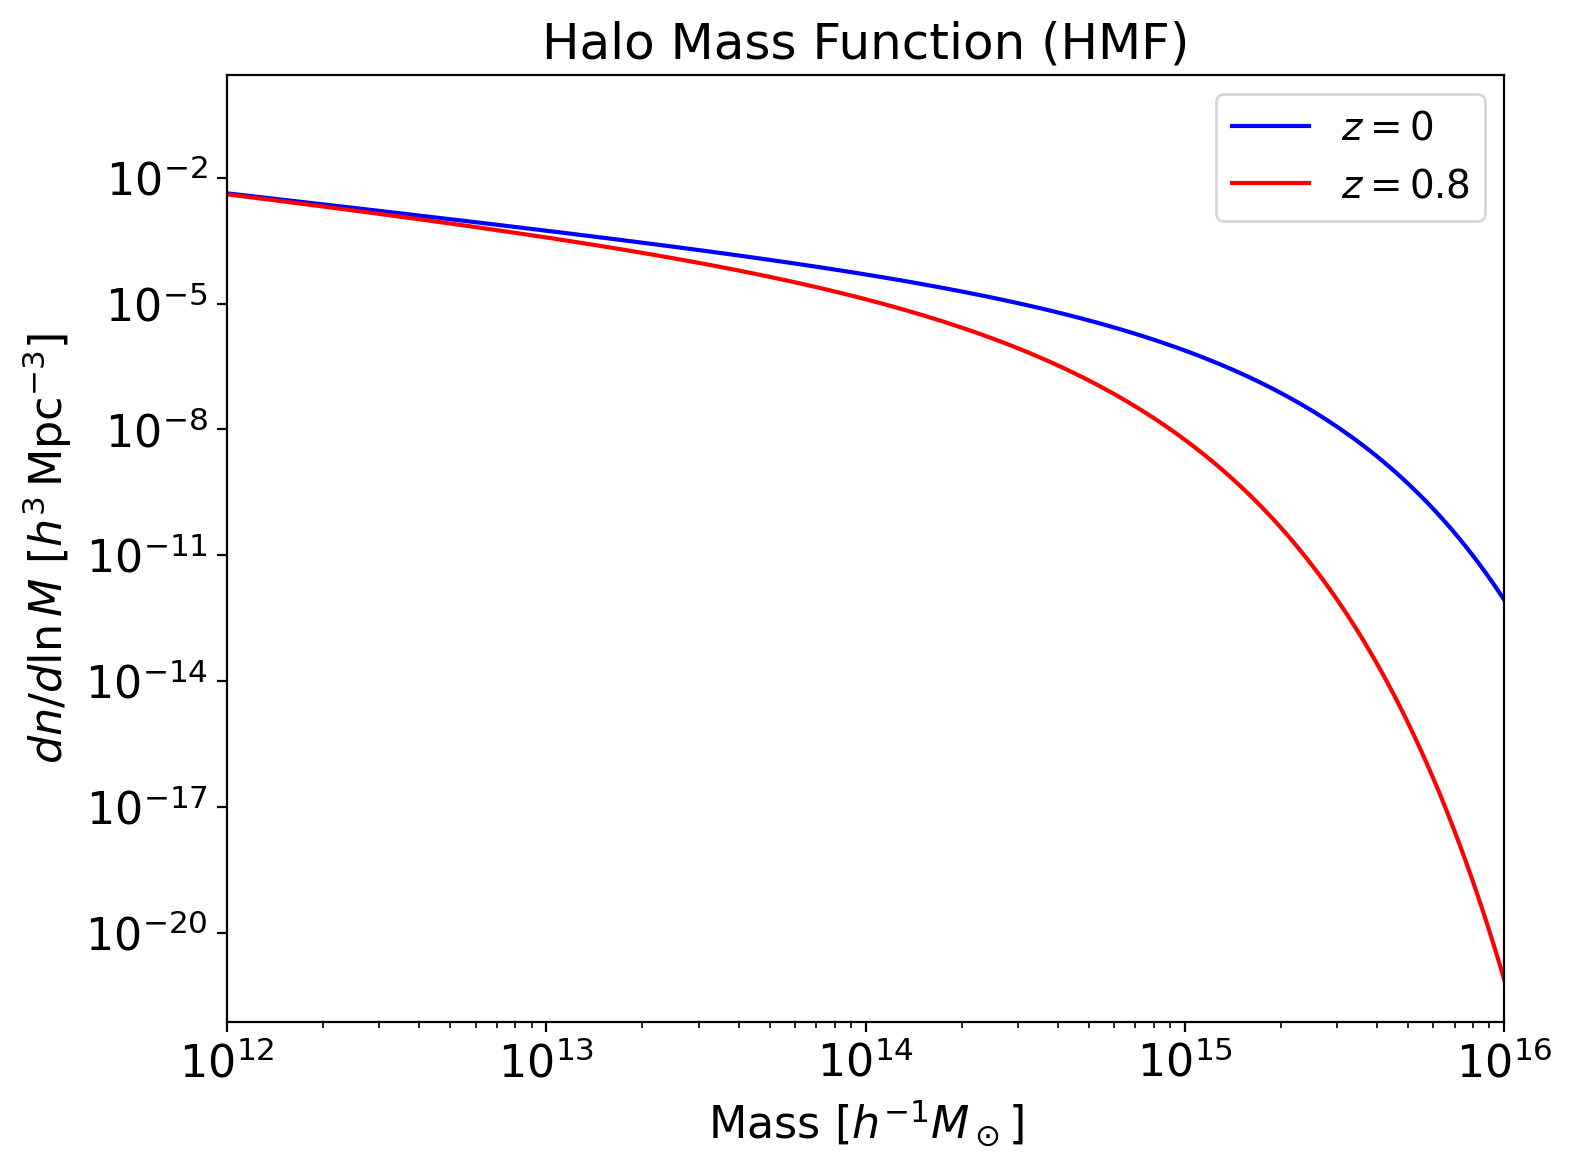

In [19]:
# 5. Plot the results
fig, ax = plt.subplots(figsize=(8, 6))

ax.loglog(M, dn_dlnM, label=f'$z={0}$', color='blue')
ax.loglog(M, dn_dlnM_2, label=f'$z={0.8}$', color='red')

# Axis labels with larger font
ax.set_xlabel(r'Mass [$h^{-1} M_\odot$]', fontsize=16)
ax.set_ylabel(r'$dn/d\ln M$ [$h^3\,\mathrm{Mpc}^{-3}$]', fontsize=16)
ax.set_title('Halo Mass Function (HMF)', fontsize=18)
ax.set_xlim(1e12,1e16)
# Grid and formatting
ax.tick_params(axis='both', which='major', labelsize=16)

# Optional: use scientific notation on axes if needed


# Layout and legend
ax.legend(fontsize=14)
plt.tight_layout()

plt.savefig('HMF.png')
plt.show()

## Cross check variance with data 

In [20]:
# As a check point, you can compare your intermediate results at z=0 to
sigma_dsigma2_crosscheck = np.loadtxt('sigma_cross_check.txt', unpack=True)
dsigma_dM = np.gradient(sigma_M**2, M)

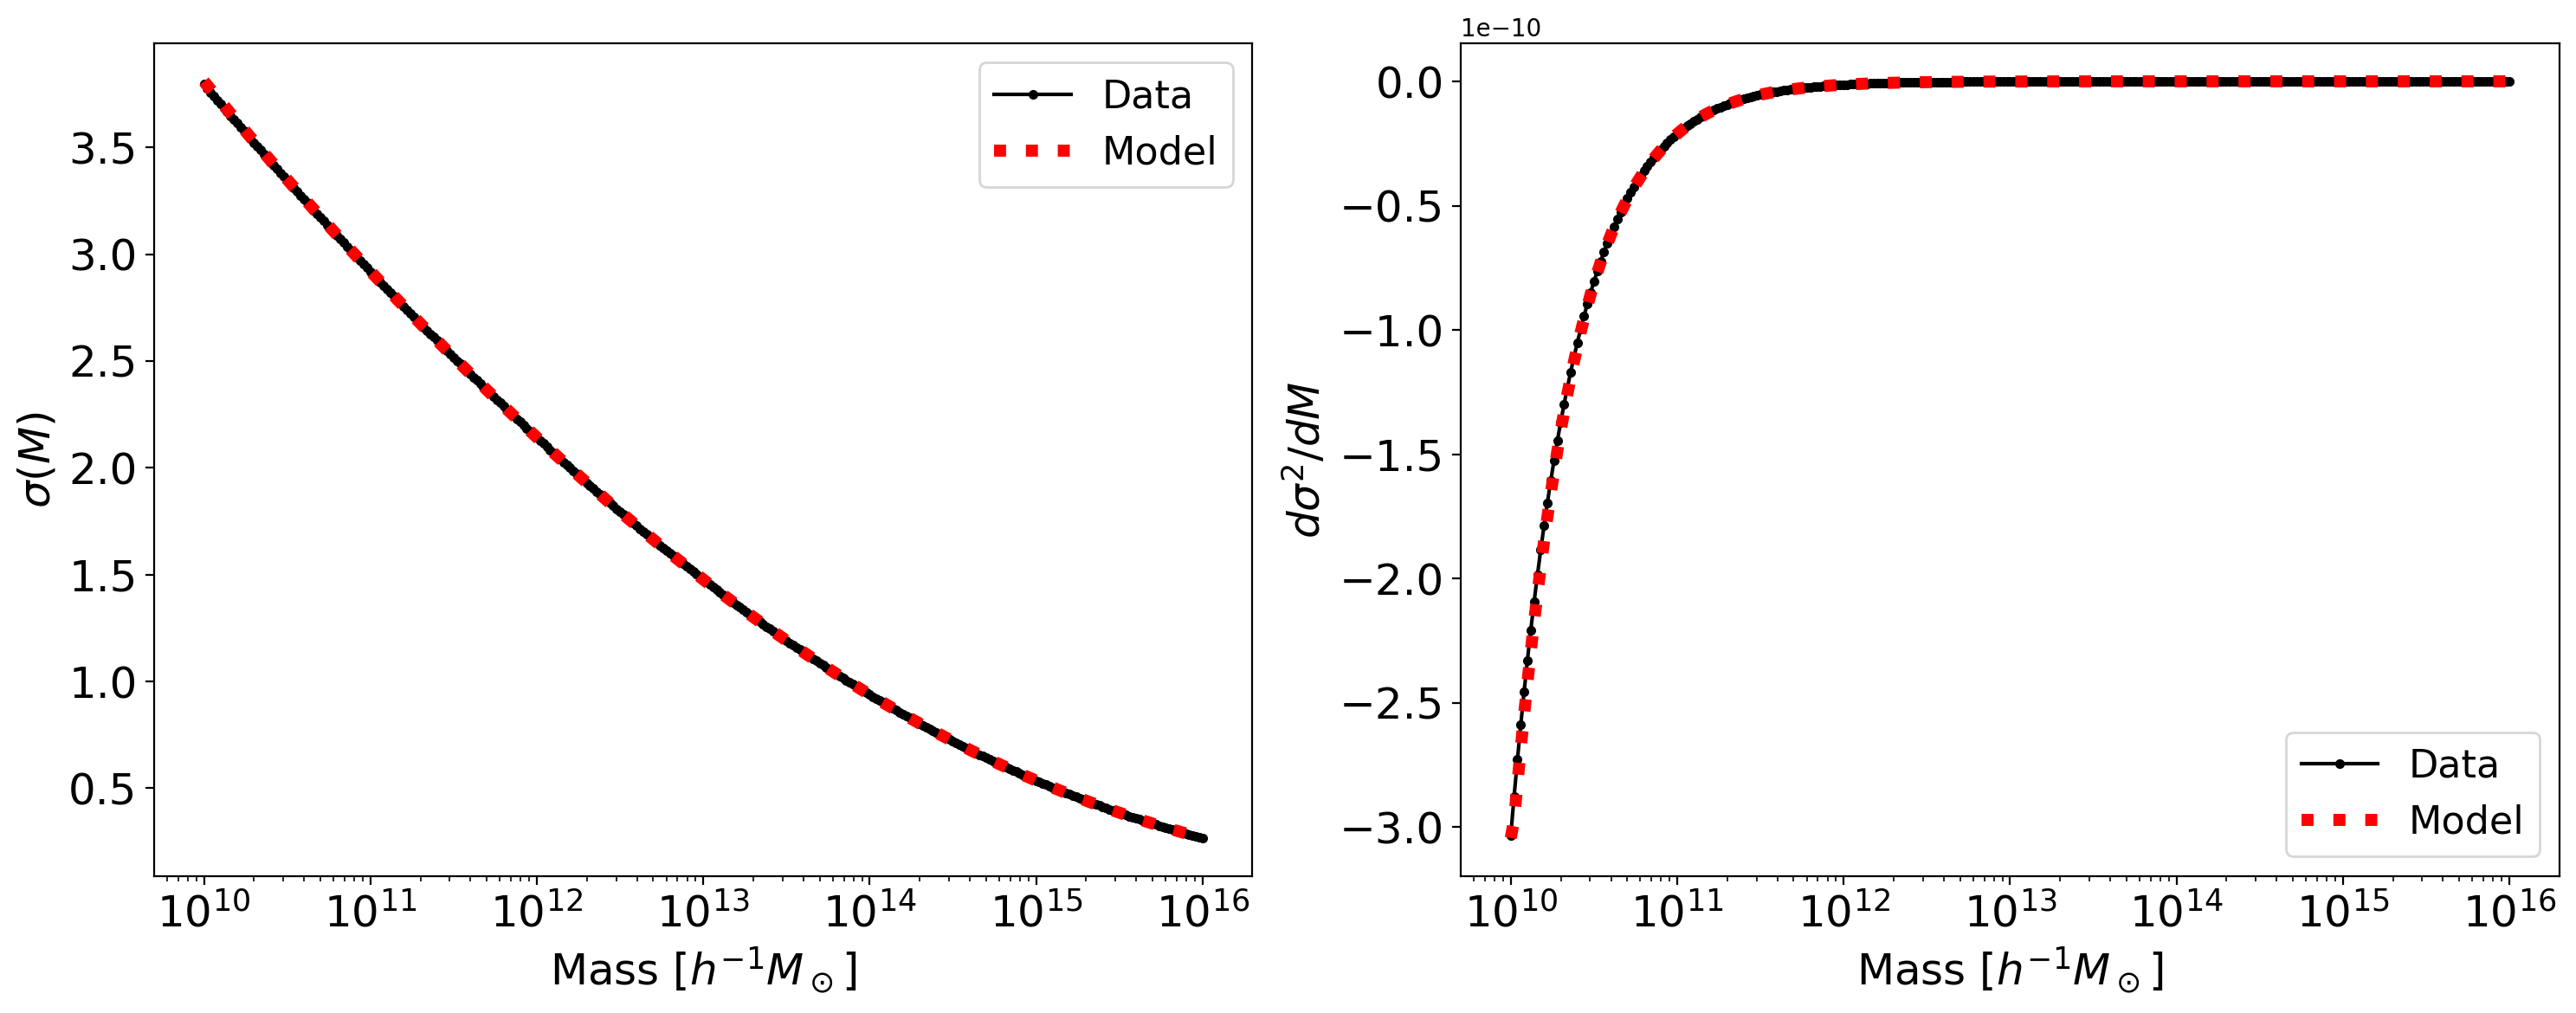

In [21]:
# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plt.subplots_adjust(wspace=1)  # Increase horizontal space between plots

# Plot σ(M)
axes[0].semilogx(sigma_dsigma2_crosscheck[0], sigma_dsigma2_crosscheck[1], label='Data', color='k', marker='o', markersize=3, linestyle='-')
axes[0].semilogx(M, sigma_M, label='Model', color='r', linestyle=':', linewidth=5)

axes[0].set_xlabel(r'Mass [$h^{-1}M_\odot$]', fontsize=18)
axes[0].set_ylabel(r'$\sigma(M)$', fontsize=18)
axes[0].legend(fontsize=16)
axes[0].tick_params(axis='both', labelsize=18)

# Plot dσ²/dM (semi-log-x)
axes[1].semilogx(sigma_dsigma2_crosscheck[0], sigma_dsigma2_crosscheck[2], label='Data', color='k', marker='o', markersize=3, linestyle='-')
axes[1].semilogx(M, dsigma_dM, label='Model', color='r', linestyle=':',linewidth=5)
axes[1].set_xlabel(r'Mass [$h^{-1}M_\odot$]', fontsize=18)
axes[1].set_ylabel(r'$d\sigma^2/dM$', fontsize=18)
axes[1].legend(fontsize=16)
axes[1].tick_params(axis='both', labelsize=18)

plt.tight_layout()
plt.savefig("sigma_model_comparison.png", dpi=300)  # Optional
plt.show()

## Cross check HMF with data 

In [22]:
# We can now also compare the mass function
dN_dlnM_crosscheck = np.loadtxt('dn_dlnM.txt', unpack=True)

In [23]:
print(np.arange(0,1,0.01)[80])

0.8


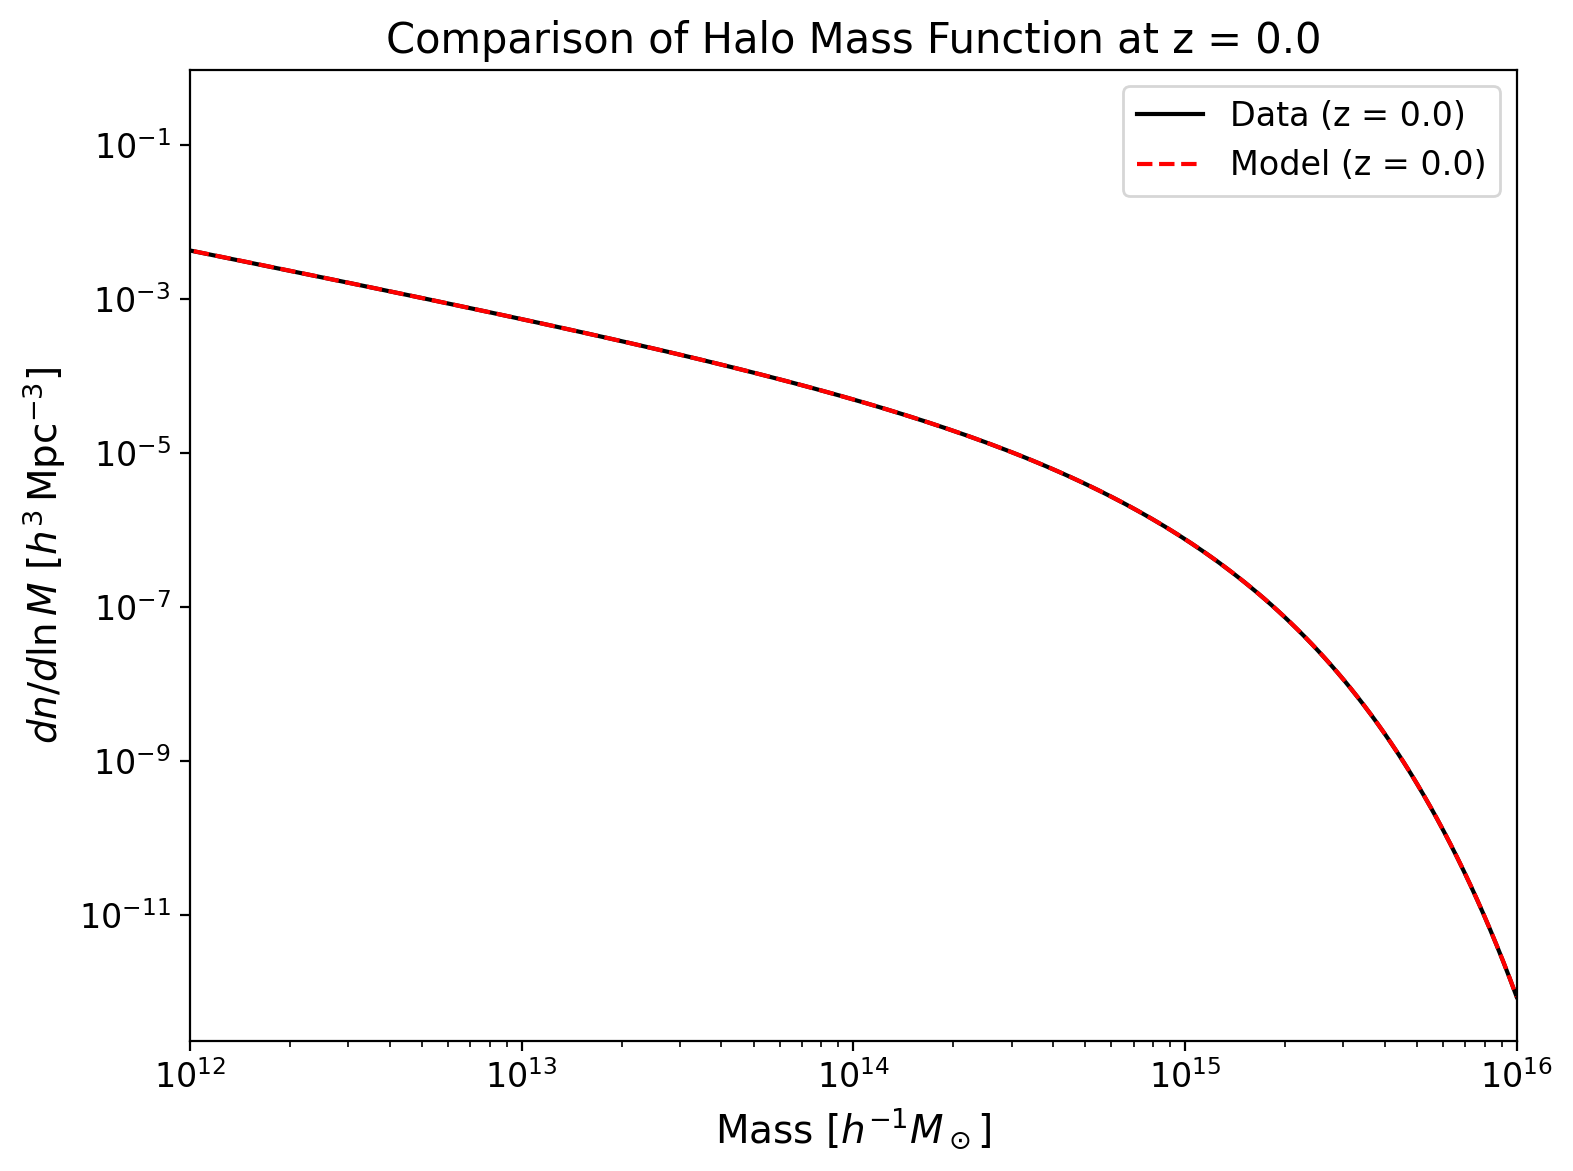

In [24]:
mass_data = dN_dlnM_crosscheck[0]         # First row = mass array
dn_dlnM_data_z0 = dN_dlnM_crosscheck[1]   # Second row = dn/dlnM at z = 0.0
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the data from the file
ax.loglog(mass_data, dn_dlnM_data_z0, label='Data (z = 0.0)', color='black', linestyle='-')

# Plot your model prediction
ax.loglog(M, dn_dlnM, label='Model (z = 0.0)', color='red' , linestyle = '--')

ax.set_xlabel(r'Mass [$h^{-1} M_\odot$]', fontsize=14)
ax.set_ylabel(r'$dn/d\ln M$ [$h^3\,\mathrm{Mpc}^{-3}$]', fontsize=14)
ax.set_title('Comparison of Halo Mass Function at z = 0.0', fontsize=15)
ax.legend(fontsize=12)
ax.set_xlim(1e12,1e16)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()


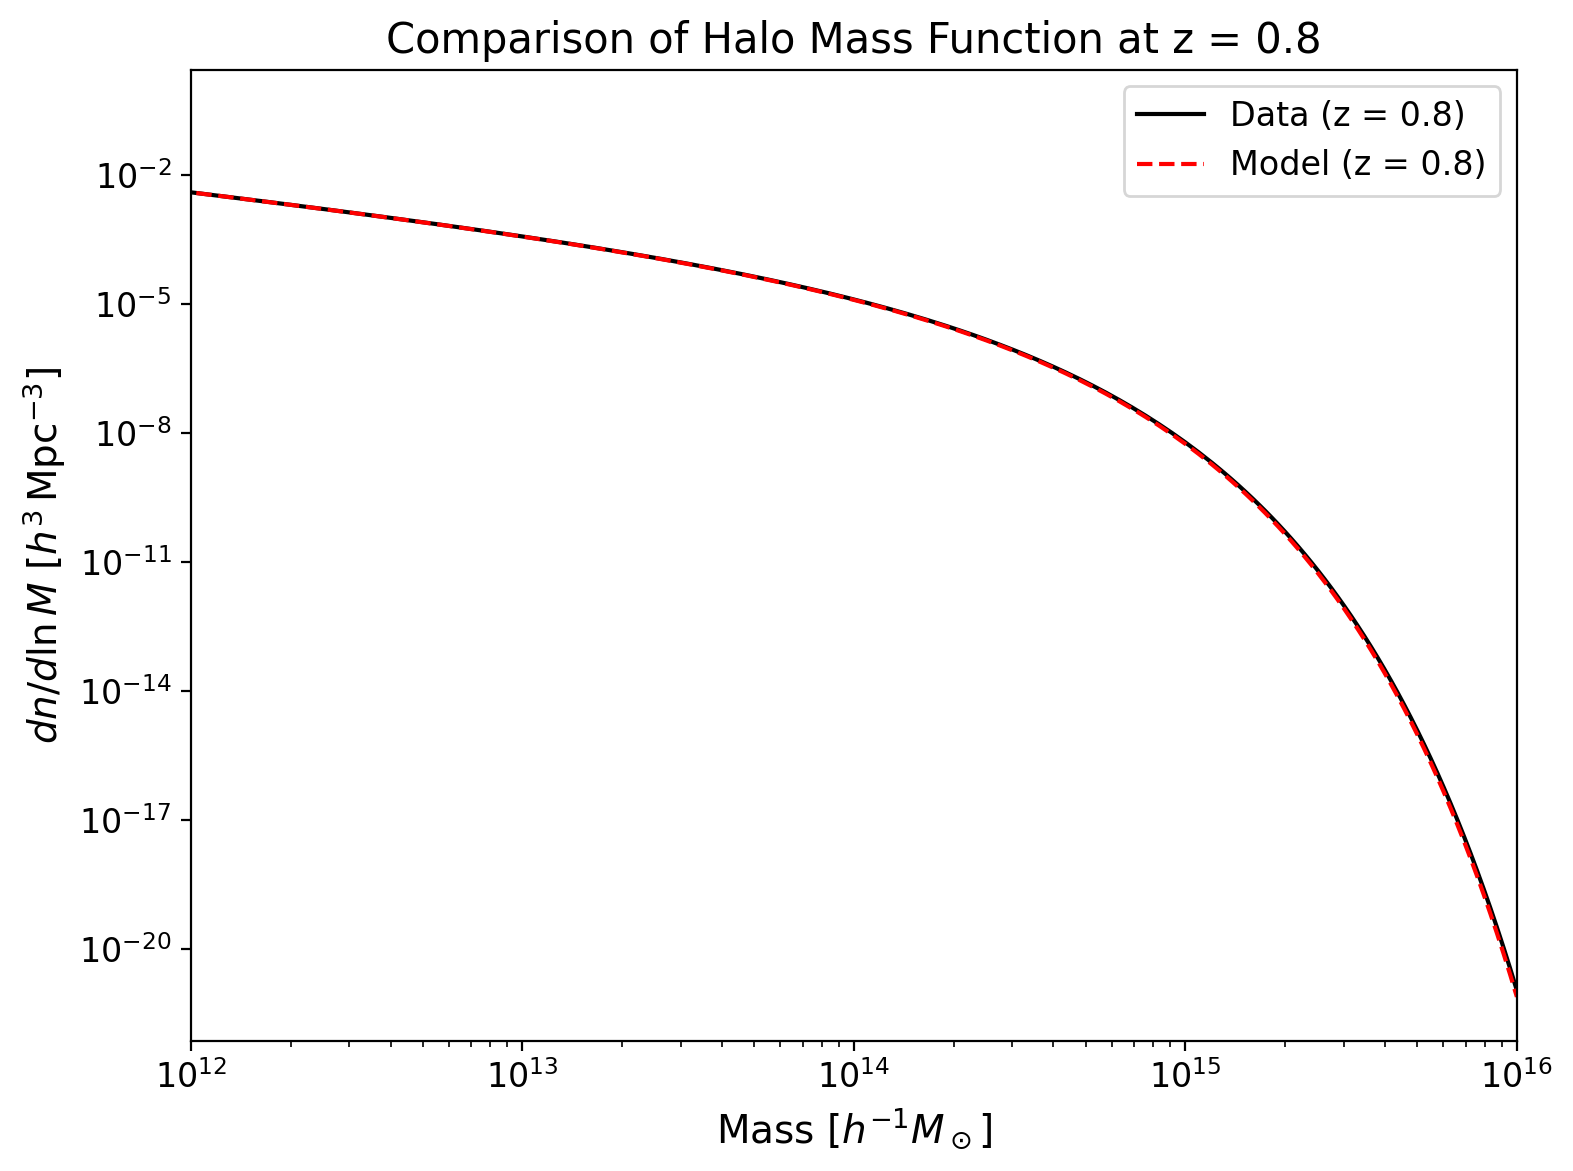

In [25]:
mass_data = dN_dlnM_crosscheck[0]           # First row = mass array
dn_dlnM_data_z08 = dN_dlnM_crosscheck[80]    # Third row = dn/dlnM at z = 0.8

fig, ax = plt.subplots(figsize=(8, 6))

# Plot the data from the file
ax.loglog(mass_data, dn_dlnM_data_z08, label='Data (z = 0.8)', color='black', linestyle='-')

# Plot your model prediction at z = 0.8
ax.loglog(M, dn_dlnM_2, label='Model (z = 0.8)', color='red', linestyle='--')

ax.set_xlabel(r'Mass [$h^{-1} M_\odot$]', fontsize=14)
ax.set_ylabel(r'$dn/d\ln M$ [$h^3\,\mathrm{Mpc}^{-3}$]', fontsize=14)
ax.set_title('Comparison of Halo Mass Function at z = 0.8', fontsize=15)
ax.legend(fontsize=12)
ax.set_xlim(1e12, 1e16)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()


## Comparision plot 

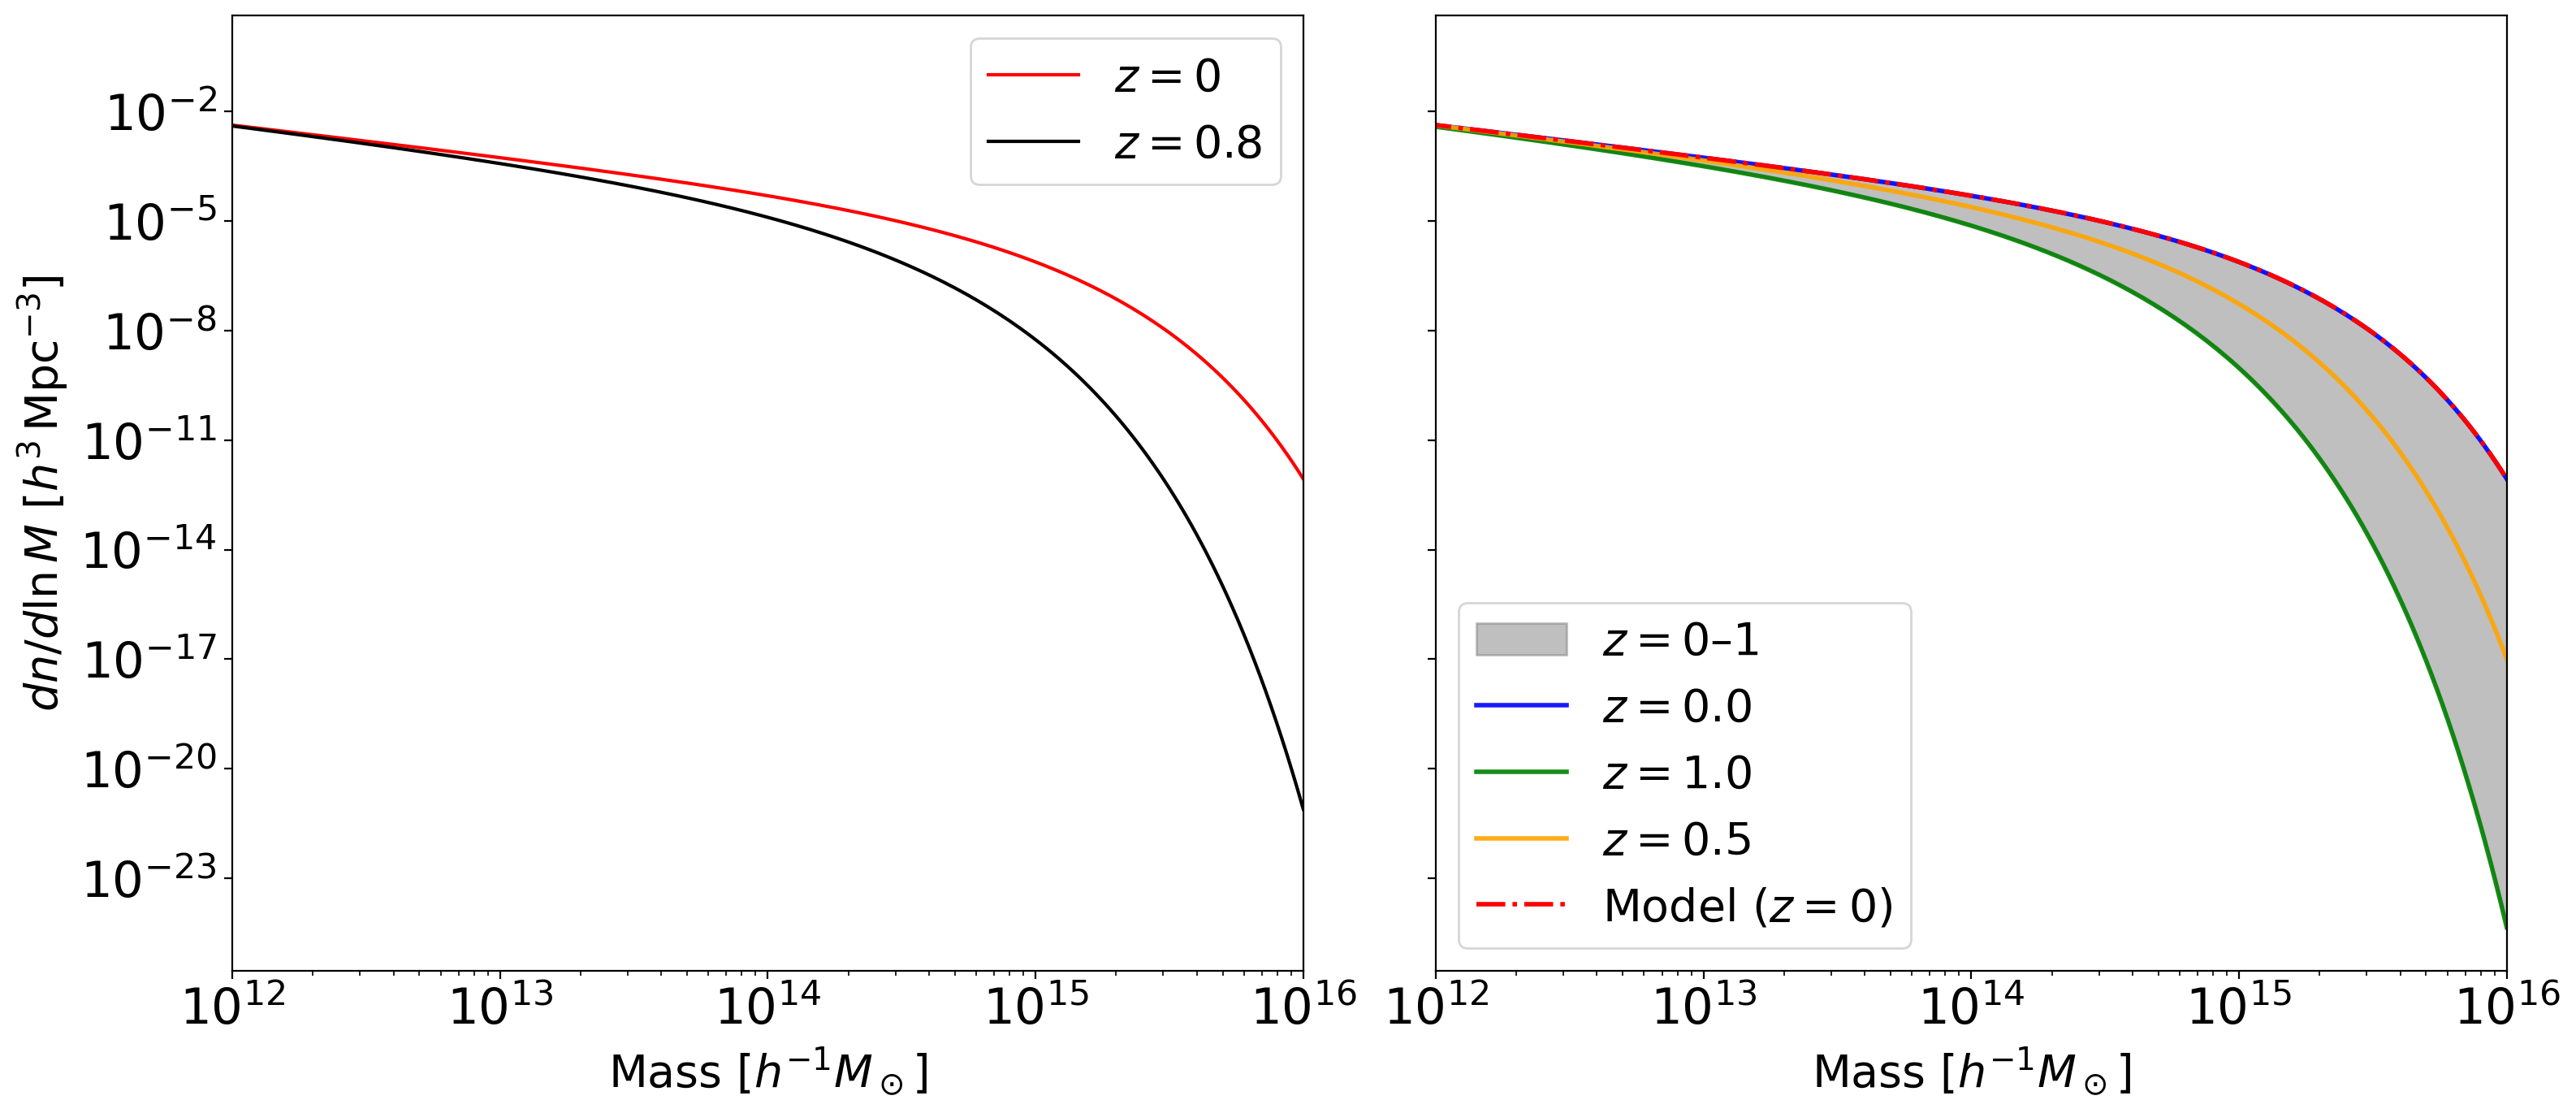

In [26]:
# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
fig.subplots_adjust(wspace=0.1)  # Reduce spacing between plots

# Font sizes
label_fontsize = 20
tick_fontsize = 22
title_fontsize = 22
legend_fontsize = 20

# Left panel: HMF at two redshifts
axes[0].loglog(M, dn_dlnM, label=r'$z=0$', color='red')
axes[0].loglog(M, dn_dlnM_2, label=r'$z=0.8$', color='k')
axes[0].set_xlabel(r'Mass [$h^{-1} M_\odot$]', fontsize=label_fontsize)
axes[0].set_ylabel(r'$dn/d\ln M$ [$h^3\,\mathrm{Mpc}^{-3}$]', fontsize=label_fontsize)
axes[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axes[0].legend(fontsize=legend_fontsize)
axes[0].set_xlim(1e12, 1e16)

# Right panel: Model vs. Data comparison

# Shaded region for cross-check data range
x = dN_dlnM_crosscheck[0]
ymin = np.min(dN_dlnM_crosscheck[1:], axis=0)
ymax = np.max(dN_dlnM_crosscheck[1:], axis=0)
axes[1].fill_between(x, ymin, ymax, color='gray', alpha=0.5, label='$z=0$–$1$')

# Highlight selected redshifts
z_indices = [0, len(dN_dlnM_crosscheck) - 2, (len(dN_dlnM_crosscheck) - 1) // 2]  # z=0, 1.00, 0.50
colors = ['blue', 'green', 'orange']
for i, idx in enumerate(z_indices):
    z_val = idx * 0.01
    label = f'$z={z_val:.1f}$'
    axes[1].loglog(x, dN_dlnM_crosscheck[idx + 1], color=colors[i], alpha=0.9, linewidth=2, label=label)

# Overplot model at z=0
axes[1].loglog(M, dn_dlnM, color='red', linewidth=2, label='Model ($z=0$)' , linestyle = '-.')

# Axes settings
axes[1].set_xlabel(r'Mass [$h^{-1} M_\odot$]', fontsize=label_fontsize)
axes[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axes[1].legend(fontsize=legend_fontsize)
axes[1].set_xlim(1e12, 1e16)

# Tight layout and high-res save
plt.tight_layout()
plt.savefig('HMF_combined_shaded_and_zlines.png', dpi=400)
plt.show()


In [41]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import camb
from scipy.optimize import bisect

# --- Assumptions: your helper functions exist in the session ---
# compute_sigma_M(pars, k, Pk, M)  -> returns (sigma_M, integrand) as before
# compute_Tinker_HMF(Delta_mean, z, pars, sigma_M, dlnsigma_dlnM, M)
# Omega_m_z(z, pars)
# pars is your baseline camb.CAMBparams (with ombh2, omch2, H0, h, As, etc.)

# Mass grid (same as you used)
M = np.logspace(10, 16, 301)

# Helper: get sigma8 from a camb params object
def get_sigma8_from_pars(pars_obj):
    res = camb.get_results(pars_obj)
    s8 = np.array(res.get_sigma8())[0]
    return s8

# Helper: tune As to reach target sigma8 (bisect on As)
def tune_As_for_sigma8(pars_template, target_sigma8, As_low_factor=1e-2, As_high_factor=1e2):
    As0 = pars_template.InitPower.As
    p_low.InitPower.As = As0 * As_low_factor
    p_high.InitPower.As = As0 * As_high_factor
   

    p_low.As = As0 * As_low_factor
    p_high.As = As0 * As_high_factor

    def f(As_val):
        p = pars_template.copy()
        p.As = As_val
        return get_sigma8_from_pars(p) - target_sigma8

    # Ensure bracket:
    if f(p_low.As) * f(p_high.As) > 0:
        raise RuntimeError("As bracket failed for sigma8 tuning. Try different factors.")

    As_solution = bisect(lambda A: f(A), p_low.As, p_high.As, xtol=1e-6, maxiter=50)
    p_final = pars_template.copy()
    p_final.As = As_solution
    return p_final

# Helper: compute HMF given a camb params object (uses your compute_sigma_M)
def compute_hmf_for_pars(pars_obj, M_array, z=0.0, Delta_mean=200.0):
    # ensure CAMB provides matter power for desired redshift
    pars_obj.set_matter_power(redshifts=[z], kmax=10.0)
    pars_obj.NonLinear = camb.model.NonLinear_none
    results = camb.get_results(pars_obj)

    kh, zlist, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=13, npoints=301)
    # pk has shape (nz, nk) — use pk[0] for the requested z
    sigma_M_arr = np.array([compute_sigma_M(pars_obj, kh, pk[0], mass)[0] for mass in M_array])
    logM = np.log(M_array)
    logsigma = np.log(sigma_M_arr)
    dlnsigma_dlnM = np.gradient(logsigma, logM)

    # Tinker expects Delta w.r.t mean: convert if you are using that convention
    Delta_eff = Delta_mean / Omega_m_z(z, pars_obj)
    dn_dlnM = compute_Tinker_HMF(Delta_eff, z, pars_obj, sigma_M_arr, dlnsigma_dlnM, M_array)
    return dn_dlnM, sigma_M_arr

# ---------------------------
# Set up two cosmologies
# ---------------------------
# Baseline reference to copy from
pars_fid = pars.copy()  # your existing params

# We want Omegam=0.3, OmegaLambda=0.7 for both; set by changing omch2 keeping ombh2 and h same
target_Om = 0.3
h_val = pars_fid.h
# ombh2 stays the same:
ombh2_val = pars_fid.ombh2
# compute required omch2 = Om * h^2 - ombh2
omch2_new = target_Om * (h_val**2) - ombh2_val
if omch2_new <= 0:
    raise RuntimeError("Computed omch2_new <= 0; check your baseline pars.h and ombh2.")

# Cosmology A: sigma8 = 0.79
pars_A = pars_fid.copy()
pars_A.omch2 = omch2_new
pars_A.Omega_m = target_Om
# If you want to enforce OmegaLambda explicitly:
# pars_A.set_params(Om0=target_Om, ombh2=ombh2_val, omch2=omch2_new)  # optional

target_s8_A = 0.79
pars_A_tuned = tune_As_for_sigma8(pars_A, target_s8_A)

# Cosmology B: sigma8 = 0.70
pars_B = pars_fid.copy()
pars_B.omch2 = omch2_new
pars_B.Omega_m = target_Om

target_s8_B = 0.70
pars_B_tuned = tune_As_for_sigma8(pars_B, target_s8_B)

# ---------------------------
# Compute HMFs
# ---------------------------
dn_A, sigmaM_A = compute_hmf_for_pars(pars_A_tuned, M, z=0.0, Delta_mean=200.0)
dn_B, sigmaM_B = compute_hmf_for_pars(pars_B_tuned, M, z=0.0, Delta_mean=200.0)

# ---------------------------
# Plot comparison
# ---------------------------
plt.figure(figsize=(8,6))
plt.loglog(M, dn_A, label=r'$\sigma_8=0.79$', color='C0', linestyle='-')
plt.loglog(M, dn_B, label=r'$\sigma_8=0.70$', color='C1', linestyle='--')
plt.xlabel(r'Mass [$h^{-1} M_\odot$]', fontsize=14)
plt.ylabel(r'$dn/d\ln M$ [$h^3\,\mathrm{Mpc}^{-3}$]', fontsize=14)
plt.xlim(1e12, 1e16)
plt.tick_params(labelsize=12)
plt.legend(fontsize=12)
plt.title('HMF sensitivity to $\sigma_8$ (with $\Omega_m=0.3$)', fontsize=14)
plt.grid(which='both', ls=':', alpha=0.4)
plt.show()

# Fractional difference (B relative to A)
frac = (dn_B - dn_A) / dn_A
plt.figure(figsize=(8,4))
plt.semilogx(M, frac*100)
plt.xlabel(r'Mass [$h^{-1} M_\odot$]', fontsize=14)
plt.ylabel('Fractional change (%)', fontsize=14)
plt.xlim(1e12, 1e16)
plt.axhline(0, color='k', lw=0.8)
plt.tick_params(labelsize=12)
plt.grid(which='both', ls=':', alpha=0.4)
plt.title('Fractional change in HMF: (0.70 vs 0.79)', fontsize=12)
plt.show()


<>:116: SyntaxWarning: invalid escape sequence '\s'
<>:116: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_98/2221479428.py:116: SyntaxWarning: invalid escape sequence '\s'
  plt.title('HMF sensitivity to $\sigma_8$ (with $\Omega_m=0.3$)', fontsize=14)
/tmp/ipykernel_98/2221479428.py:116: SyntaxWarning: invalid escape sequence '\s'
  plt.title('HMF sensitivity to $\sigma_8$ (with $\Omega_m=0.3$)', fontsize=14)


NameError: name 'p_low' is not defined

## Compare with numerical simulation

In [27]:
!wget https://cloud.physik.lmu.de/index.php/f/92537851

--2025-08-08 09:19:02--  https://cloud.physik.lmu.de/index.php/f/92537851
Resolving cloud.physik.lmu.de (cloud.physik.lmu.de)... 192.54.42.239, 2001:4ca0:4102:0:192:54:42:239
Connecting to cloud.physik.lmu.de (cloud.physik.lmu.de)|192.54.42.239|:443... connected.
HTTP request sent, awaiting response... 401 Unauthorized

Username/Password Authentication Failed.


In [28]:
with h5py.File('Illustris-TNG300-1-Dark_halocat.h5', 'r') as f:
    # Explore the content of the hdf5 "directory"
    print(f)
    for key in f.keys():
        print(key)
    # Let us take a look at the first snapshot
    print(f['snap_98'].keys())
    print(f['snap_98/M200c'])
    for key in f['snap_98/M200c'].attrs.keys():
        print(key, ':', f['snap_98/M200c'].attrs[key])
        # Load halo masses from snapshot 6
    halo_mass = f['snap_98/M200c'][:]  # This is likely in Msun/h
    print("Number of halos:", len(halo_mass))
    print("First 10 halo masses:", halo_mass[:10])

<HDF5 file "Illustris-TNG300-1-Dark_halocat.h5" (mode r)>
snap_61
snap_71
snap_81
snap_98
<KeysViewHDF5 ['M200c', 'M200m']>
<HDF5 dataset "M200c": shape (11911082,), type "<f4">
units : 10^10 h^-1 M_sun
Number of halos: 11911082
First 10 halo masses: [100643.85   87137.06   65536.305  58354.47   55923.895  38921.86
  30633.152  37889.51   25720.99   41444.496]


In [29]:
import h5py

with h5py.File('Illustris-TNG300-1-Dark_halocat.h5', 'r') as f:
    # List all groups/datasets at the root
    print(f.keys())
    
    # Sometimes the header is stored under a specific group, e.g. 'Header' or snapshot group like 'snap_98'
    # For example, check snap_98 attributes:
    snap = f['snap_98']
    print(snap.attrs.keys())  # list all attributes
    
    # Look for redshift or expansion factor attribute
    if 'Redshift' in snap.attrs:
        z = snap.attrs['Redshift']
        print("Redshift:", z)
    elif 'ExpansionFactor' in snap.attrs:
        a = snap.attrs['ExpansionFactor']
        z = 1.0/a - 1.0
        print("Redshift computed from ExpansionFactor:", z)
    else:
        # Maybe check root or other groups
        for key in f.attrs.keys():
            print(key, f.attrs[key])


<KeysViewHDF5 ['snap_61', 'snap_71', 'snap_81', 'snap_98']>
<KeysViewHDF5 []>


In [30]:
snap_num = 98
redshift_lookup = {99: 0.0, 98: 0.1, 81: 0.5, 71: 1.0, 61: 2.0}
z = redshift_lookup.get(snap_num, None)
print(f"Snapshot {snap_num} corresponds approximately to redshift z = {z}")


Snapshot 98 corresponds approximately to redshift z = 0.1


In [31]:
log_mass = np.log10(halo_mass)

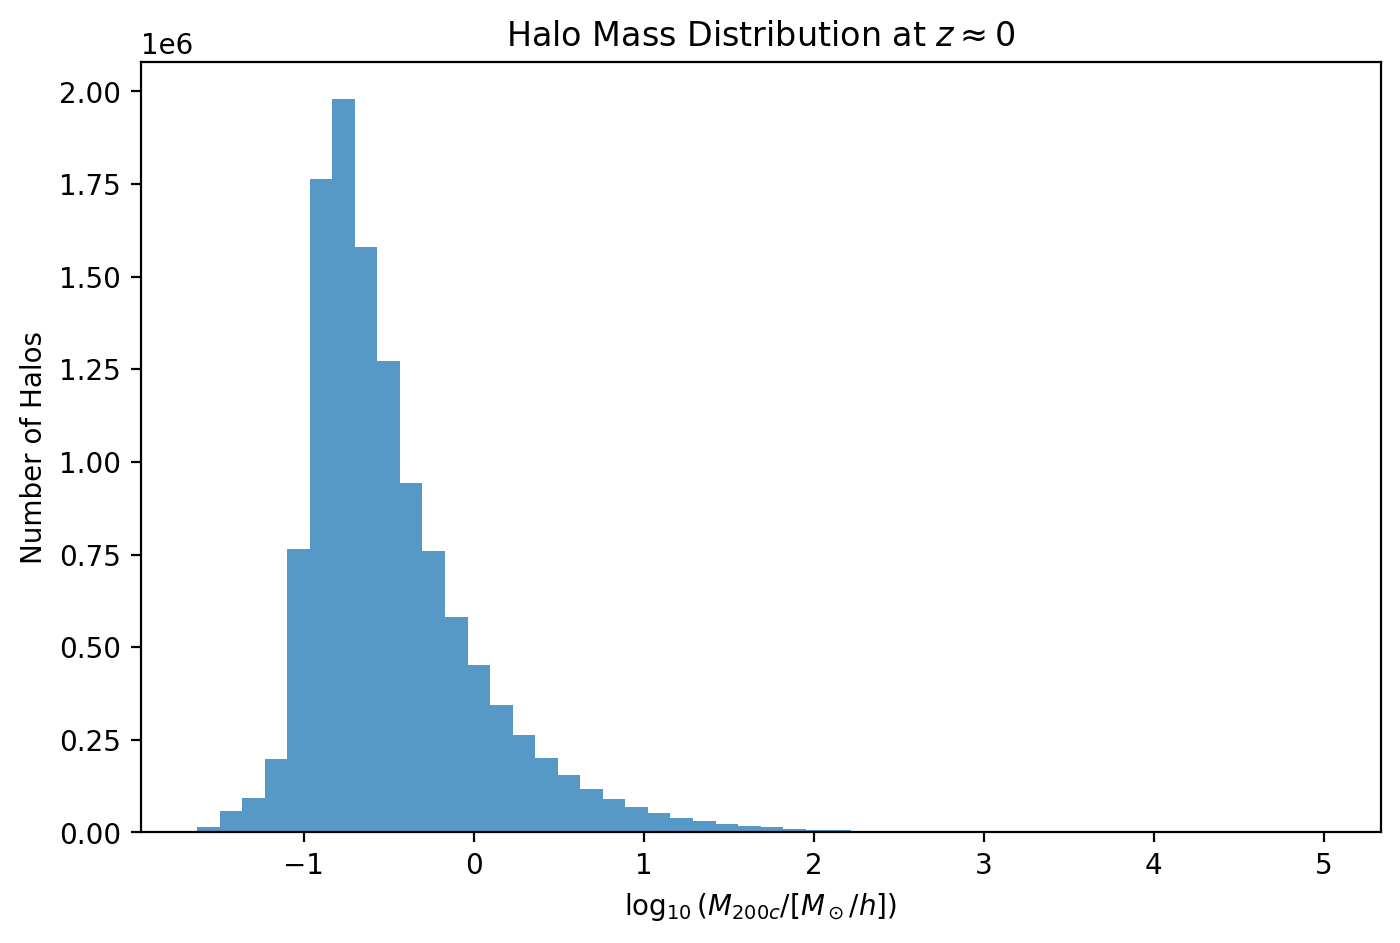

In [32]:
plt.figure(figsize=(8,5))
plt.hist(log_mass, bins=50, color='C0', alpha=0.75)
plt.xlabel(r'$\log_{10}(M_{200c} / [M_\odot/h])$')
plt.ylabel('Number of Halos')
plt.title('Halo Mass Distribution at $z \\approx 0$')
plt.show()

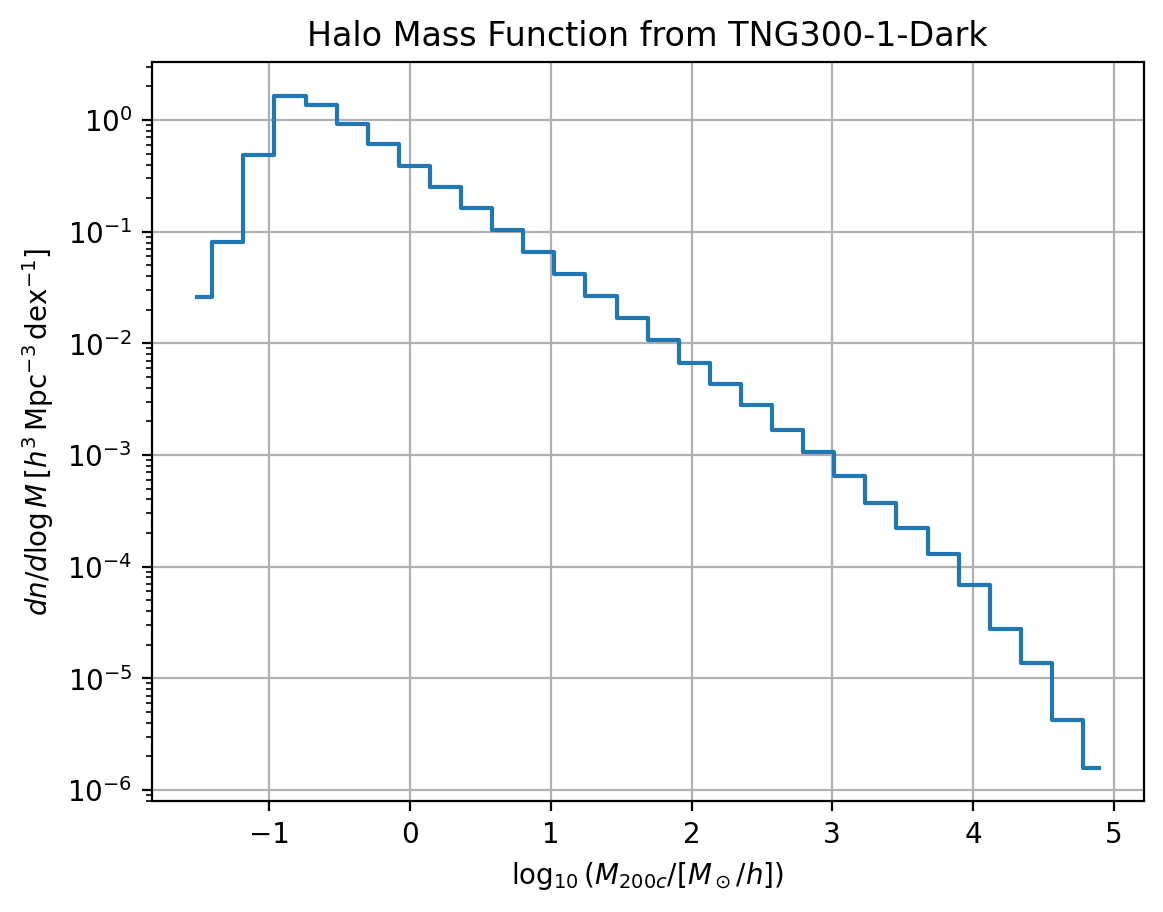

In [33]:
volume = (205)**3  # Mpc^3/h^3 if TNG300 box, adjust if different

hist, bin_edges = np.histogram(log_mass, bins=30)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
dn_dlogM = hist / np.diff(bin_edges) / volume  # h^3 / Mpc^3 / dex

plt.figure()
plt.plot(bin_centers, dn_dlogM, drawstyle='steps-mid')
#plt.plot(bin_centers, dn_dlnM, color='black')
plt.xlabel(r'$\log_{10}(M_{200c} / [M_\odot/h])$')
plt.ylabel(r'$dn/d\log M \, [h^3 \, \mathrm{Mpc}^{-3} \, \mathrm{dex}^{-1}]$')
plt.title('Halo Mass Function from TNG300-1-Dark')
plt.yscale('log')
plt.grid(True)
plt.show()

In [34]:
volume = (205)**3  # Mpc^3/h^3 if TNG300 box, adjust if different

hist, bin_edges = np.histogram(log_mass, bins=30)
bin_width = (bin_edges[-1] - bin_edges[0])
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

dn_dlnM_new = compute_Tinker_HMF(200/Omega_m_z(z,pars), 0.01, pars, sigma_M, dlnsigma_dlnM, M)
dn_dlnM_new =   dn_dlnM_new * np.log(10) 

print(bin_centers)
print(bin_width)

[-1.5159426  -1.2949686  -1.0739946  -0.8530208  -0.6320468  -0.4110729
 -0.19009906  0.03087485  0.25184882  0.4728228   0.69379663  0.9147705
  1.1357445   1.3567183   1.5776922   1.7986661   2.01964     2.240614
  2.461588    2.6825619   2.9035356   3.1245093   3.3454833   3.5664573
  3.7874312   4.008405    4.229379    4.4503527   4.6713266   4.8923006 ]
6.629217


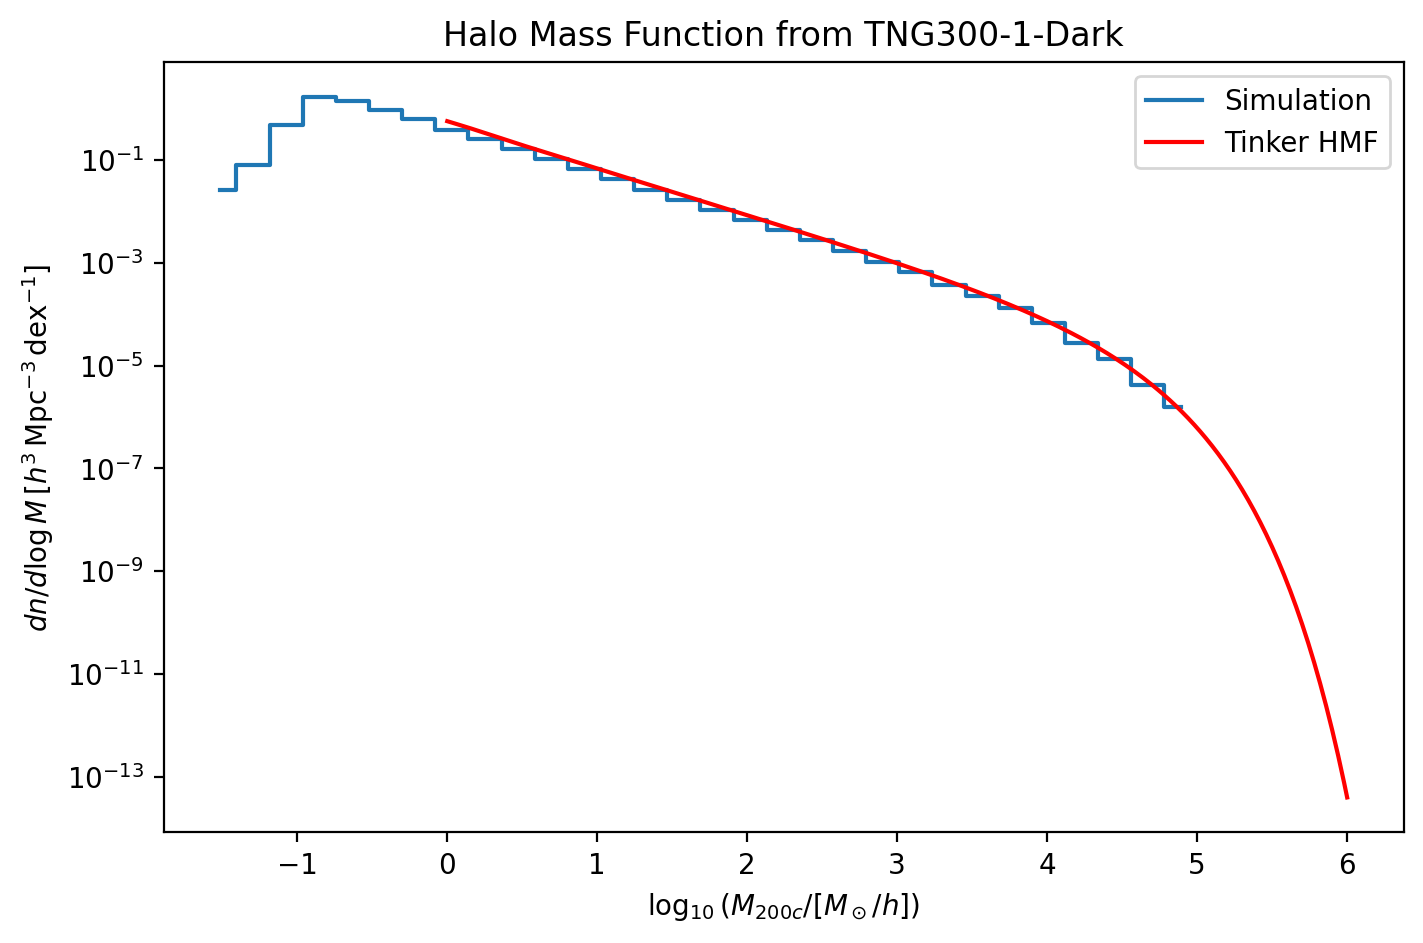

In [35]:
# Assuming log_mass, compute_Tinker_HMF, Omega_m_z, z, pars, sigma_M, dlnsigma_dlnM, M are defined

volume = 205**3  # Mpc^3/h^3 (TNG300 box size)

# Histogram of log halo masses from simulation
hist, bin_edges = np.histogram(log_mass, bins=30)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_widths = np.diff(bin_edges)  # per-bin widths in dex

# Calculate number density dn/dlog10M [h^3/Mpc^3/dex]
dn_dlogM = hist / bin_widths / volume

# Compute analytic halo mass function dn/dlnM and convert to dn/dlog10M
dn_dlnM_new = compute_Tinker_HMF(200/0.3089, 0.01, pars, sigma_M, dlnsigma_dlnM, M)
dn_dlog10M_new = dn_dlnM_new * np.log(10)  # convert natural log to log10

# Plot simulation and analytic halo mass functions
plt.figure(figsize=(8,5))
plt.plot(bin_centers, dn_dlogM, drawstyle='steps-mid', label='Simulation')
plt.plot(np.log10(M / 1e10), dn_dlog10M_new, label='Tinker HMF', color='red')
plt.xlabel(r'$\log_{10}(M_{200c} / [M_\odot/h])$')
plt.ylabel(r'$dn/d\log M \, [h^3 \, \mathrm{Mpc}^{-3} \, \mathrm{dex}^{-1}]$')
plt.title('Halo Mass Function from TNG300-1-Dark')
plt.yscale('log')
plt.legend()
plt.show()


# Cosmological sensitivity

## Explore the sensitivity of the halo mass function to a selection of cosmological parameters.. 